In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

# The Metropolis-Hastings Algorithm

We build the Metropolis Adjusted Langevin dynamics algorithm.
This algorithm uses the gradient of the log of the target distribution to
guide the proposal distribution.
It's a pretty cool algorithm that shares some similarities with the NUTS (which is better but more complicated).

## Metropolis Adjusted Langevin Dynamics (MALA)

The proposal distribution of the MALA algorithm is given by

$$
q(x'|x) = \mathcal{N}\left(x' | x + \Delta t \nabla \log p(x), 2\Delta t^2 I\right),
$$

where $\Delta t$ is a step size parameter.
Recall from calculus that the gradient of a function points in the direction of steepest ascent.
So, the MALA algorithm is proposing a new state that is a random walk in the direction of steepest ascent of the log of the target distribution.
It tries to take a step in the direction of the peak of the distribution.
The gradient of the log of the target distribution is called the *score* function.
Remember the name if you dig deeper into generative models such as diffusion.

We provide a basic implementation of the MALA algorithm below.
We use `pytorch` to compute the gradient of the log of the target distribution.

In [6]:
import torch 


def propose(z, dt, log_h):
    """Propose a new point using the Langevin dynamics."""
    z.requires_grad_()
    log_h_z = log_h(z)
    grad_log_h_z = torch.autograd.grad(log_h_z, z)[0]
    return z + grad_log_h_z * dt + torch.randn(z.shape[0]) * math.sqrt(2 * dt), log_h_z, grad_log_h_z


def mala(x0, log_h, n, dt, args=()):
    """Random walk metropolis.
    
    Arguments
    ----------
    x0     -- The initial point.
    log_h  -- The logarithm of the target distribution.
    n      -- The maximum number of steps you want to take.
    dt     -- The time step you want to use.
    
    Returns
    -------
    x, acceptance_rate  -- The samples and the acceptance rate.
    """
    d = x0.shape[0]
    X = []
    x0.requires_grad_()
    log_h_x0 = log_h(x0)
    grad_log_h_x0 = torch.autograd.grad(log_h_x0, x0)[0]
    count_accepted = 0
    for t in tqdm.tqdm(range(1, n + 1)):
        # Propose
        x_next, log_h_x_next, grad_log_h_x_next = propose(x0, dt, log_h)
        # Compute acceptance ratio
        log_alpha = log_h_x_next - log_h_x0 \
            - 0.25 * dt * (
                ((x0 - x_next + dt * grad_log_h_x_next) ** 2).sum()
                - ((x_next - x0 + dt * grad_log_h_x0) ** 2).sum()
            )
        alpha = torch.exp(log_alpha)
        u = torch.rand(1)
        if u <= alpha:
            x0 = x_next
            log_h_x0 = log_h_x_next
            count_accepted += 1
        X.append(x0.detach().numpy())
    # Empirical acceptance rate
    acceptance_rate = count_accepted / (1. * n)
    X = np.array(X)
    return X, acceptance_rate

## Example 1: Sampling from a Gaussian with MALA

Let's take $\mathcal{X}=\mathbb{R}^2$ and:

$$
\pi(x) \propto h(x) = \exp\left\{-\frac{1}{2}\left(x-\mu\right)^T\Lambda(x-\mu)\right\},
$$

where $\mu\in\mathbb{R}^2$ is the mean and $\Lambda = \Sigma^{-1}\in\mathbb{R}^{2\times 2}$ is the precision matrix.
We need:

$$
\log h(x) = -\frac{1}{2}(x-\mu)^T\Lambda (x-\mu),
$$

and

$$
\nabla \log h(x) = -\Lambda (x-\mu).
$$

In [17]:


# The parameters of the distribution from which we wish to sample
mu = torch.tensor([5., 2.])
Sigma = torch.tensor([[1., .4],
                      [.4, 0.2]]) # This has to be positive definite - otherwise you will get garbage!

Lambda = torch.linalg.inv(Sigma)


def log_h_mvn(x):
    tmp = x - mu
    return -0.5 * tmp.T @ (Lambda @ tmp)


# Initialiazation:
x0 = torch.randn(2)
# Parameters of the proposal:
dt = 0.005
# Number of steps:
n = 10000

# Start sampling
X, acceptance_rate = mala(x0, log_h_mvn, n, dt, args=(mu, Lambda))

print(f"Acceptance rate: {acceptance_rate:1.2f}")

100%|██████████| 10000/10000 [00:01<00:00, 7296.78it/s]

Acceptance rate: 0.75


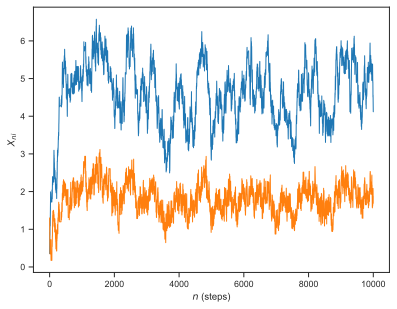

In [18]:
fig, ax = plt.subplots()
ax.plot(X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

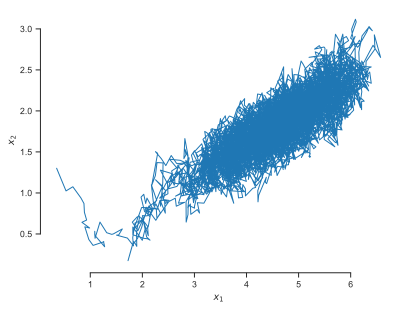

In [19]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

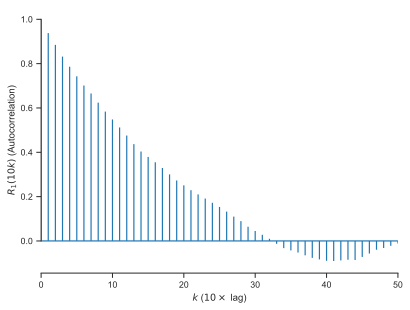

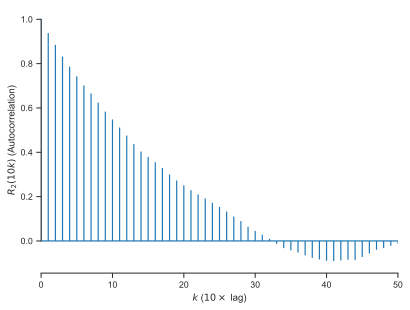

In [20]:
# How many samples do you want to burn?
burn = 500
# How many samples do you want to throw in between?
thin = 10 # Keep one every thin samples 
# Here are the remaining samples:
X_rest = X[burn::thin]
for i in range(X_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=50)
    ax.set_xlim(0, 50)
    ax.set_ylabel('$R_{%d}(%d k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);
    sns.despine(trim=True);

### Questions

- Play with the `thin` parameter until you get a satisfactory autocorrelation plot.